# BAKU - Time Measurement and Code Generation
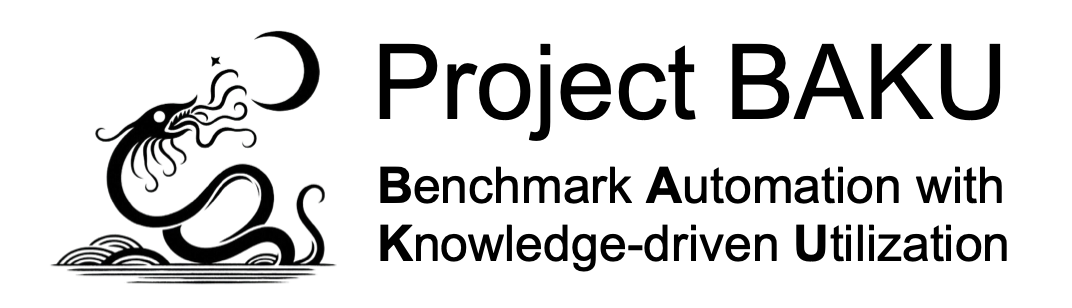

This notebook is designed for testing language models (LLMs). The primary objective is to collect data on the performance of LLMs regarding the time spent on code generation, the percentage of generated code that can be compiled, and to determine the asymptotic behavior of time concerning the maximum number of tokens in the networks. For better code organization, the code is structured in classes to ensure a functional pipeline.

### Imports

In [1]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer
) #the model

import torch #for the model

import numpy as np #to better use of the arrays

import time #measure time

import matplotlib.pyplot as plt #plots

import pandas as pd #for csv

import statsmodels.api as sm #for run stats
import seaborn as sns

from google.colab import drive #to import the csv and other data
from google.colab import auth
from google.colab import userdata
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload
from huggingface_hub import login


import subprocess #for write file...
import random
import string
import os
import sys

In [2]:
simulation_path = '/content/drive/MyDrive/Colab_Notebooks/Baku/data/models_data.csv' #simulation data
models_path = '/content/drive/MyDrive/Colab_Notebooks/Baku/data/model_values.csv' #models generation data
input_path = '/content/drive/MyDrive/Colab_Notebooks/Baku/data/code_add.csv' #inputs data

drive.mount('/content/drive')
auth.authenticate_user()

Mounted at /content/drive


In [3]:
os.environ["code-llama"] = userdata.get("code-llama") #only for LLAMA3 model's
login(os.environ["code-llama"])

### Classes

In [26]:
class DataLoader:
    def __init__(self, data_path:str):
        try:
            self.data_path = data_path
            self.dataframe = pd.read_csv(data_path)
            print("Data Loaded.")
        except:
            raise Exception("Data couldn't be loaded.")


    def save(self):
        try:
            self.dataframe.to_csv(self.data_path, index=False)
            print("All data updated.")
        except:
            raise Exception("Data couldn't be uploaded.")

    def column_values(self,column_name):
        try:
            return self.dataframe[column_name].values
        except:
            raise Exception("Column must be wrong.")



    def new_row(self, new_values: list):#Matches two list to form a new data row
      if len(new_values) != len(self.dataframe.columns):
          raise ValueError("The number of values does not match the number of columns.")

      # Create a DataFrame from the new row values
      new_row = pd.DataFrame([dict(zip(self.dataframe.columns, new_values))])

      self.dataframe = pd.concat([self.dataframe, new_row], ignore_index=True)

    def static_row_string(self,id,ignore_columns=""):#chose a value to generate
        if(id==0):
            return "Impossible to pick the value."

        else:

            if not ignore_columns == "": #if there is a column...
                static = self.dataframe.drop(ignore_columns, axis=1).iloc[id]

            else:
                static = self.dataframe.iloc[id]

            static = static.to_string(index=False)
            return static

    def random_row_string(self,ignore_columns=""):
        random = self.dataframe.sample()
        id = random.get('id').values[0]

        if not ignore_columns == "":#if there is a column...
            random = random.drop(ignore_columns, axis=1)

        random = random.to_string(index=False)
        return random,id


In [31]:
class CodeGeneration:

    def __init__(self,model,model_name,tokenizer,data : DataLoader,input_str: str,input_id : int,
                 max_length : int, base_code: str = "", topology="regression"):
        self.model = model
        self.model_name = model_name
        self.data = data
        self.input_str = input_str
        self.max_length = max_length
        self.input_id = input_id
        self.tokenizer = tokenizer

        if topology == "performance":
            self.template =  f"""
        Generate a C program optimized for the following Linux `perf` statistics:
        {self.input_str}

        - **Requirements**:
            1. The program must contain a main function that receives the data and invokes the processing logic.
            2. Address performance bottlenecks (e.g., cache misses, branch mispredictions) using:
            - Loop unrolling, SIMD intrinsics (AVX/SSE), memory alignment.
            - Data structure optimizations (e.g., cache-friendly layouts).
            3. **Fuzzer-Specific Constraints**:
            - Process raw bytes from `const uint8_t* data` and `size_t size` as input.
            - Avoid undefined behavior: validate buffer bounds, sanitize inputs.
            - Exclude I/O operations (e.g., `printf`, file access).
            4. Code Style:
            - Zero comments or explanations.
            - Use preprocessor directives only when critical (e.g., `#include <stdint.h>`).
            5. Enclose the code between <Program> tags.

        - **Output Format**:
            <Program>
            // C code here
            </Program>
        """

        else:
             self.template = f"""
        Complete the following code, {self.input_str}:
        {base_code}


        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.

        - **Output Format**:
            <Program>
            {base_code}
            </Program>
        """

        self.dif_seconds = 0
        self.ouput = ""
        self.program_name = ""
        self.program = ""


    def generate_code(self,response=True):#Measure time and generate the code
        input_time = time.time()
        inputs = self.tokenizer(self.template, return_tensors="pt").to(self.model.device)
        outputs = self.model.generate(**inputs, max_length=self.max_length) #model output
        output_time = time.time()

        self.dif_seconds = (output_time - input_time) #time measure
        decoded_output = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        self.output = decoded_output

        if(response):
            print('The output was:' + decoded_output)
            print(f'Time spend in the code generation: {self.dif_seconds}')


    def get_output_list(self):#Return the data from the program generation
        if (self.program_name == "") or (self.program == ""):
            program = self.program_extratcion()

        if(self.base_code in self.program):#Do not accept base code as a generated code

            gpu_name = self.get_gpu_name()
            len_program = len(self.tokenizer.encode(self.program)) #count the amount of tokens in the program
            return [self.model_name,
                    self.dif_seconds,
                    self.program_name,
                    gpu_name,
                    self.input_id,
                    0,
                    -1]

        gpu_name = self.get_gpu_name()
        len_program = len(self.tokenizer.encode(self.program)) #count the amount of tokens in the program
        return [self.model_name,
                self.dif_seconds,
                self.program_name,
                gpu_name,
                self.input_id,
                0,
                len_program]


    def program_extratcion(self):#Return the program generated
        self.name_generator()

        if self.program == "":
            final_program = ""
            suboutput_list = self.output.split("<Program>")

            for subprogram in (suboutput_list):
                program = subprogram.split("</Program>")[0]

                if(program.find("}")!=-1):
                    final_program = program

            self.program = final_program

        return self.program

    def get_gpu_name(self): #Get GPU used for the code gen
        try:
            # All the informations about the current GPU
            gpu_info = subprocess.check_output(
                'nvidia-smi --query-gpu=name,driver_version,memory.total,memory.used,memory.free,utilization.gpu --format=csv,noheader',
                shell=True, text=True
            )
            return gpu_info.strip().split(',')[0]
        except Exception as e:
            print(f"Erro: {e}")
            return "Unkown"

    def name_generator(self,size=4): #Randomly generate a new file name

        if self.program_name == "" :
            chars=string.ascii_uppercase + string.digits
            random_name = ''.join(random.choice(chars) for _ in range(size))
            while random_name in self.data.column_values('code_name'):
                random_name = ''.join(random.choice(chars) for _ in range(size))
            self.program_name = random_name




In [28]:
class GenerationPipeline:
    def __init__(
            self,
            model: object,
            model_name: str,
            tokenizer: object,
            simulation_data_path: str,
            models_data_path: str,
            input_data_path: str,
            topology: str = 'regression'  # Nome corrigido
        ):
        self.model = model
        self.model_name = model_name
        self.tokenizer = tokenizer
        self.input_data = DataLoader(input_data_path)
        self.models_data = DataLoader(models_data_path)
        self.simulation_data = DataLoader(simulation_data_path)

        if topology == "performance":
            self.ignore_coluns = ['Suite','Program','id']

        else:
            self.ignore_coluns = ['id','type']

        self.topology = topology

    def upload_file_to_drive(self,code_name,program):#Upload file to drive for colab
        try:
            folder_id = '1y_BZ7M_Rpq7q4TEoRQiGMkfDWhR0okan'
            local_file_path = f"/content/{code_name}.c"
            drive_service = build('drive', 'v3')



            with open(local_file_path, "w") as file:
             file.write(program)


            file_metadata = {
                'name': f'{code_name}.c',
                'parents': [folder_id]
            }

            media = MediaFileUpload(local_file_path, mimetype='text/plain')
            service = build('drive', 'v3')
            uploaded_file = service.files().create(body=file_metadata, media_body=media, fields='id').execute()

            print(f"File uploaded successfully. File ID: {uploaded_file.get('id')}")
        except Exception as e:
            print(f"File could not be uploaded. ERROR: {e}")

    def single_code_generation(self, max_len: int, static: bool = False, id: int = 0) -> float:#Single Program Generation
        try:
            input_value = ""

            if static:#Static Value
                input_value,input_id = self.input_data.static_row_string(id,self.ignore_coluns)

            else:#Random
                input_value,input_id = self.input_data.random_row_string(self.ignore_coluns)


            base_code = """ int f(int a) {
                return 0;
                }"""

            generator = CodeGeneration(
            model=self.model,
            model_name=self.model_name,
            tokenizer=self.tokenizer,
            data=self.models_data,
            input_str=input_value,
            input_id=input_id,
            max_length=max_len,
            base_code=base_code,
            topology=self.topology
        )

            generator.generate_code()

            program = generator.program_extratcion()

            output_list = generator.get_output_list()

            if(output_list[6] > 0):
                self.upload_file_to_drive(output_list[2],program)#Save generation

            self.models_data.new_row(output_list)
            self.models_data.save()

            print("Program Generated:\n" + program)
            return output_list[1]
        except Exception as e:
            print(f"ERRO: {e}")



    def single_simulation(self,first_max_length=1024,max_lenght_pow=1,sample=12):#Simulate different generation for time measure

        current_max_length = first_max_length#Begin with some length
        time_array = np.array([])

        for i in range(max_lenght_pow):

            for j in range(sample):
                time_temp = self.single_code_generation(current_max_length) #time spent

                time_array = np.append(time_array,time_temp)


            simulation_output = [self.model_name,
                                 np.mean(time_array),
                                 np.std(time_array),
                                 0,
                                 0,
                                 sample,
                                 current_max_length
                                ,np.min(time_array),
                                 np.max(time_array)]


            self.simulation_data.new_row(simulation_output)
            self.simulation_data.save()

            time_array = np.empty(0)

            current_max_length *= 2 #make it double beacause could grow better

        print("Simulation Done!")

    def chain_code_generation():
        return 0
        #empty for now

    def chain_simulation():
        return 0
        #empty for now


### AI Config

In [29]:
inputss = DataLoader(input_path)

Data Loaded.


In [8]:
model_name = "meta-llama/Meta-Llama-3.1-8B-Instruct" #Obs: Run in free plan; Some alucinations (tuning?);
# model_name = 'deepseek-ai/DeepSeek-Coder-V2-Lite-Instruct' #Obs: Don't Run in free; Clean code; Faster;
# model_name = 'bigcode/starcoder2-7b' #Obs: Lazy; Alucinations; Bigger than llama;
# model_name = 'facebook/llvm-compiler-7b'#Need to be test properly

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    trust_remote_code = True
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code = True,
    torch_dtype = torch.bfloat16
).cuda()

input_text = "write a quick sort algorithm in C"
inputs = tokenizer(input_text, return_tensors="pt").to(model.device)
outputs = model.generate(**inputs, max_length=128)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


write a quick sort algorithm in C++
Quick Sort Algorithm
Quick sort is a divide-and-conquer algorithm that picks a 'pivot' element from the array and partitions the other elements into two sub-arrays, according to whether they are less than or greater than the pivot. The sub-arrays are then recursively sorted.
Here is a simple implementation of Quick Sort in C++:
```cpp
#include <iostream>

// Function to swap two elements
void swap(int* a, int* b) {
    int temp = *a;
    *a = *b;
    *b = temp;
}

// Function to partition the


### Generation (Single tests and simulation)

In [ ]:
pipeline = GenerationPipeline(model, model_name, tokenizer,simulation_path,models_path,input_path)
seconds = pipeline.single_code_generation(512)
seconds

In [ ]:
pipeline.single_simulation(512,1,12)

### Stats and DataFrame

In [ ]:
def linear_regression(model_name,x='max_length',y='seconds'):
  try:
    model_values_path = '/content/drive/MyDrive/Colab_Notebooks/Baku/data/model_values.csv'

    models_values = pd.read_csv(model_values_path)
    models_values = models_values.dropna()
    models_values = models_values[models_values.get('model_name') == model_name]

    sns.regplot(x=x, y=y, data=models_values)

    plt.show()

    X = sm.add_constant(models_values[x], has_constant='add')

    model = sm.OLS(models_values[y], X)
    results = model.fit()

    coefficients = results.params
    print("\nIntercept:", coefficients[0])
    print("Slope:", coefficients[x])

    print(results.summary())
  except Exception as e:
    print(f"File could not be loaded. ERROR: {e}")


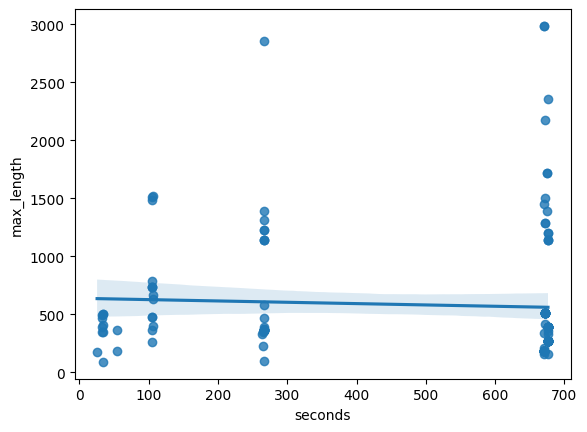


Intercept: 637.8730409297873
Slope: -0.11475665332016485
                            OLS Regression Results                            
Dep. Variable:             max_length   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.3885
Date:                Mon, 17 Feb 2025   Prob (F-statistic):              0.534
Time:                        13:37:17   Log-Likelihood:                -1128.0
No. Observations:                 146   AIC:                             2260.
Df Residuals:                     144   BIC:                             2266.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

<ipython-input-14-4e4a49e54c78>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("\nIntercept:", coefficients[0])


In [ ]:
llama_name = 'meta-llama/Meta-Llama-3.1-8B-Instruct'

linear_regression(llama_name,x='seconds',y='max_length')

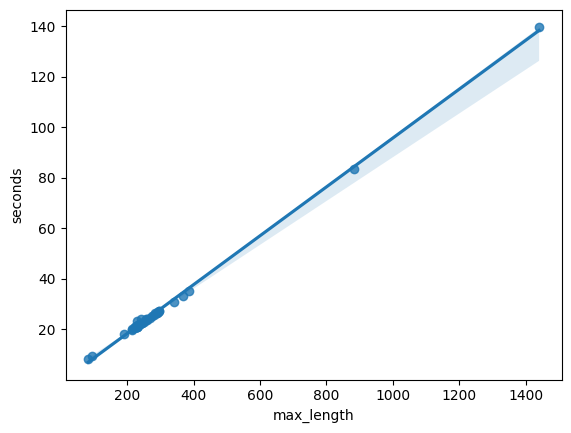


Intercept: -1.110990084102074
Slope: 0.09687842104472978
                            OLS Regression Results                            
Dep. Variable:                seconds   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 4.193e+04
Date:                Mon, 17 Feb 2025   Prob (F-statistic):           2.87e-77
Time:                        11:33:41   Log-Likelihood:                -52.452
No. Observations:                  54   AIC:                             108.9
Df Residuals:                      52   BIC:                             112.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

<ipython-input-16-904860b79074>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("\nIntercept:", coefficients[0])


In [ ]:
deep_name = 'deepseek-ai/DeepSeek-Coder-V2-Lite-Instruct'

linear_regression(deep_name)

In [ ]:
#clang -g --fsanitize=address,undefined,signed-integer-overflow -fno-sanitize-recover=all file.c